<div style="float: right; margin: 0px 15px 15px 0px;">x
</div>
<h1> Assignment 3 - MNIST Dataset</h1>
<em> <strong>Deep Learning - MITxPro </strong></em>
<br><br>
Written by Felipe Dominguez<br>
03/05/23 <br>

In [24]:
import torch
import torch.nn as nn
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time, copy
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from torch.utils.data import TensorDataset, DataLoader 

import matplotlib.pyplot as plt

# device config (train our model on GPU if it is available which is much faster)
# For Nvidia - 
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # For Mac:


# Define GPU
if not torch.backends.mps.is_available():
    torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('mps')
device

device(type='mps')

In [25]:
# Create class model
class SimpleClassifier2Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        
        super(SimpleClassifier2Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [26]:
# Utility functions for plotting your results!
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[phase+'_'+metric])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        # Important! We need to flatten every datapoint
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


In [27]:
# Your code here!

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']
    
    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # This ensures all of our datapoints are flattened
                # before feeding them to our model
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = float(running_corrects) / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (based on validation)
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

#     time_elapsed = time.time() - since
    #print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, training_curves    
        
        

In [28]:
# Transform data points into tensor and normalize it
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)
# We will split out train dataset into train and validation!
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)

In [29]:
# Finding the share of the data for the input_size
print('Data Shape: ', mnist_test.data.shape)
input_size = mnist_test.data.shape[1] * mnist_test.data.shape[2]

# Define the length if hidden layers
hidden_size1 = 162
hidden_size2 = 162
num_classes = 10

# Define learning_rate and num_epochs
learning_rate = 0.001
num_epochs = 50

Data Shape:  torch.Size([10000, 28, 28])


In [30]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 50000, 'val': 10000, 'test': 10000}


In [31]:
# Create the two_layer model

two_layer_model = SimpleClassifier2Layer(input_size, hidden_size1, hidden_size2, num_classes).to(device)
two_layer_model

SimpleClassifier2Layer(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=162, bias=True)
    (1): ReLU()
    (2): Linear(in_features=162, out_features=162, bias=True)
    (3): ReLU()
    (4): Linear(in_features=162, out_features=10, bias=True)
  )
)

In [32]:
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(two_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
two_layer_model, training_curves_two_layer = train_model(two_layer_model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.4122 Acc: 0.8788
val   Loss: 0.2568 Acc: 0.9262
test  Loss: 0.2355 Acc: 0.9312

Epoch 2/50
----------
train Loss: 0.1961 Acc: 0.9404
val   Loss: 0.1811 Acc: 0.9462
test  Loss: 0.1622 Acc: 0.9497

Epoch 3/50
----------
train Loss: 0.1396 Acc: 0.9572
val   Loss: 0.1449 Acc: 0.9576
test  Loss: 0.1304 Acc: 0.9580

Epoch 4/50
----------
train Loss: 0.1095 Acc: 0.9664
val   Loss: 0.1309 Acc: 0.9625
test  Loss: 0.1188 Acc: 0.9614

Epoch 5/50
----------
train Loss: 0.0889 Acc: 0.9728
val   Loss: 0.1154 Acc: 0.9666
test  Loss: 0.1066 Acc: 0.9666

Epoch 6/50
----------
train Loss: 0.0735 Acc: 0.9774
val   Loss: 0.1067 Acc: 0.9678
test  Loss: 0.0984 Acc: 0.9685

Epoch 7/50
----------
train Loss: 0.0606 Acc: 0.9816
val   Loss: 0.1131 Acc: 0.9678
test  Loss: 0.1020 Acc: 0.9688

Epoch 8/50
----------
train Loss: 0.0501 Acc: 0.9847
val   Loss: 0.1070 Acc: 0.9690
test  Loss: 0.0947 Acc: 0.9719

Epoch 9/50
----------
train Loss: 0.0425 Acc: 0.9875
val   Loss: 0.1088

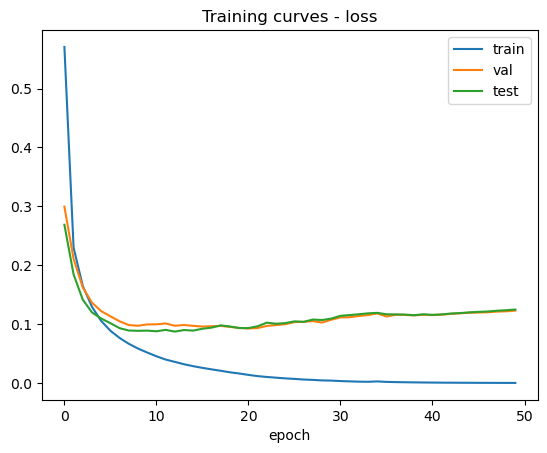

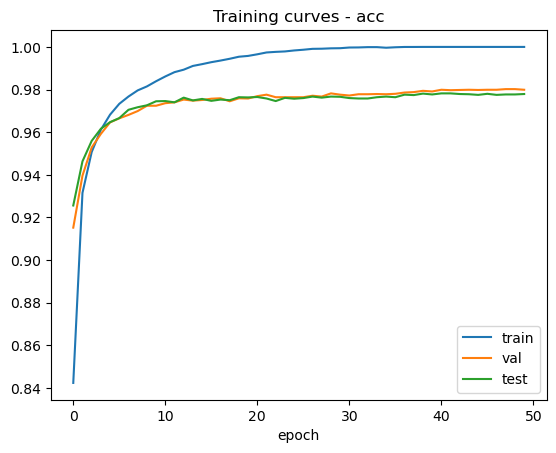

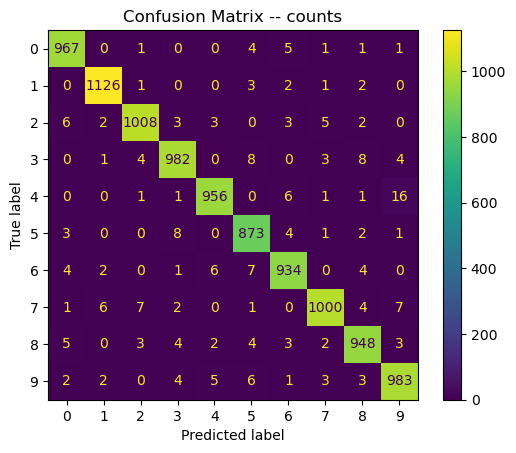

In [23]:
plot_training_curves(training_curves_two_layer, phases=['train', 'val', 'test'])
res = plot_cm(two_layer_model, device, dataloaders, phase='test')